## Importar Dataset

In [ ]:
import os
import ast
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/')
# método em Python usado para alterar o diretório de trabalho atual para o caminho especificado.
path = "/content/drive/MyDrive/Artigos_IC/"
os.chdir(path)
import shutil
shutil.copy('/content/drive/MyDrive/Artigos_IC/out_clean.csv', '/content/')

Mounted at /content/drive


'/content/out_clean.csv'

## Importanto bibliotecas para o Deep Learning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/out_clean.csv', index_col=0)
df.columns=df.columns.str.replace(' ','_')
# Garantir que a coluna `smell` seja interpretada como string
df['agreement_experts_has_smell_name'] = df['agreement_experts_has_smell_name'].astype(str)

smell = df['agreement_experts_has_smell_name']

In [ ]:
#df = df.drop('start_line',axis=1)
df = df.drop('smell',axis=1)
#df = df.drop('end_line',axis=1)
#df = df.drop('commit_hash',axis=1)
df = df.drop('agreement_experts_has_smell',axis=1)
#df = df.drop('agreement_smell_type',axis=1)
#df = df.drop('agreement_has_smell',axis=1)
df = df.drop('severity',axis=1)
#df = df.drop('id',axis=1)
#df = df.drop('reviewer_id',axis=1)
#df = df.drop('sample_id',axis=1)
#df = df.drop('review_timestamp',axis=1)
#df = df.drop('code_name', axis=1)
#df = df.drop('repository', axis=1)
#df = df.drop('path',axis=1)
#df = df.drop('link',axis=1)
#df = df.drop('is_from_industry_relevant_project',axis=1)
#df = df.drop('organic_filerelativepath',axis=1)
#df = df.drop('organic_startline',axis=1)
#df = df.drop('organic_endline',axis=1)
#df = df.drop('pmd_package',axis=1)
#df = df.drop('pmd_file',axis=1)
#df = df.drop('pmd_line',axis=1)
#df = df.drop('pmd_description',axis=1)
#df = df.drop('pmd_rule_set',axis=1)
#df = df.drop('implementation_project_name',axis=1)
#df = df.drop('implementation_code_name',axis=1)
#df = df.drop('implementation_type_name',axis=1)
#df = df.drop('implementation_method_name',axis=1)
#df = df.drop('implementation_method_start_line_no',axis=1)
#df = df.drop('implementation_cause_of_the_smell',axis=1)
#df = df.drop('designite_project_name',axis=1)
#df = df.drop('designite_implementation_smell',axis=1)
#df = df.drop('designite_design_smell',axis=1)
#df = df.drop('designite_package_name',axis=1)
#df = df.drop('designite_type_name', axis=1)
#df = df.drop('ck_class_file',axis=1)
#df = df.drop('ck_method_file',axis=1)
#df = df.drop('ck_method_class',axis=1)
#df = df.drop('ck_method',axis=1)
#df = df.drop('ck_class',axis=1)
#df = df.drop('ck_class_type',axis=1)
#df = df.drop('ck_method_constructor',axis=1)
#df = df.drop('ck_method_line',axis=1)
#df = df.drop('system_name',axis=1)
#df = df.drop('designite_cause_of_the_smell',axis=1)
#df = df.drop('system',axis=1)
#df = df.drop('smell_designite', axis=1)
df = df.drop('type',axis=1)

# ALgoritmos de Deep learning tirados de outros artigos

### Inicializando variaveis de teste

In [11]:
# Step 2: Separate Features (X) and Labels (y)
# Assuming 'longmethod', 'feature_envy', 'dataclass', and 'blob' are the label columns.
X = df.drop('agreement_experts_has_smell_name', axis=1)
y = smell
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

num_classes = len(one_hot_encoder.categories_)
# Step 3: Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



#  GRU,CNN, LSTM e MLP

In [ ]:
# Step 4: Scale the Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape data for CNN and LSTM (if needed)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 5a: MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid for multi-label classification
])
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5b: CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5c: LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7521 - loss: 0.3183 - val_accuracy: 0.9991 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9937 - loss: 0.0178 - val_accuracy: 0.9991 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9973 - loss: 0.0068 - val_accuracy: 0.9995 - val_loss: 9.9040e-04 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9976 - loss: 0.0046 - val_accuracy: 0.9995 - val_loss: 5.8981e-04 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9984 - loss: 0.0031 - val_accuracy: 0.9995 - val_loss: 6.4279e-04 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9978 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 3.2434e-04 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9982 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6059 - loss: 0.4594 - val_accuracy: 0.7096 - val_loss: 0.2586 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7484 - loss: 0.2288 - val_accuracy: 0.7605 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7891 - loss: 0.1701 - val_accuracy: 0.8356 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8341 - loss: 0.1387 - val_accuracy: 0.8485 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8304 - loss: 0.1337 - val_accuracy: 0.9000 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8403 - loss: 0.1278 - val_accuracy: 0.8671 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8469 - loss: 0.1241 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.7018 - loss: 0.3893 - val_accuracy: 0.7735 - val_loss: 0.2169 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7735 - loss: 0.2219 - val_accuracy: 0.7735 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.7713 - loss: 0.2199 - val_accuracy: 0.7735 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.7804 - loss: 0.2029 - val_accuracy: 0.7698 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.7852 - loss: 0.1516 - val_accuracy: 0.7735 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.7808 - loss: 0.1529 - val_accuracy: 0.7855 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7816 - l

In [ ]:
# Redimensionar os dados para 3D
X_train_gru = np.expand_dims(X_train, axis=1)  # (batch_size, time_steps=1, feature_dim=num_features)
X_test_gru = np.expand_dims(X_test, axis=1)

# Construir o modelo GRU
model_gru = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),  # (time_steps, feature_dim)
    GRU(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Ajustado para multi-label classification
])

# Compilar o modelo
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history_gru = model_gru.fit(X_train_gru, y_train, epochs=10, batch_size=4, verbose=1)

Epoch 1/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9388 - loss: 0.0840
Epoch 2/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9958 - loss: 0.0053
Epoch 3/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9969 - loss: 0.0034
Epoch 4/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9971 - loss: 0.0039
Epoch 5/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9972 - loss: 0.0050
Epoch 6/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9981 - loss: 0.0035
Epoch 7/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9969 - loss: 0.0030
Epoch 8/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9977 - loss: 0.0030
Epoch 9/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9978 - loss: 0.0027
Epoch 10/10
2698/2698 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9986 - loss: 0.0020


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model: MLP
Classification Report:
              precision    recall  f1-score   support

        blob       1.00      1.00      1.00       280
   dataclass       1.00      1.00      1.00       246
 featureenvy       1.00      1.00      1.00       152
  longmethod       1.00      1.00      1.00       115
        none       1.00      1.00      1.00      1905

   micro avg       1.00      1.00      1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698
 samples avg       1.00      1.00      1.00      2698

Acurácia
1.0


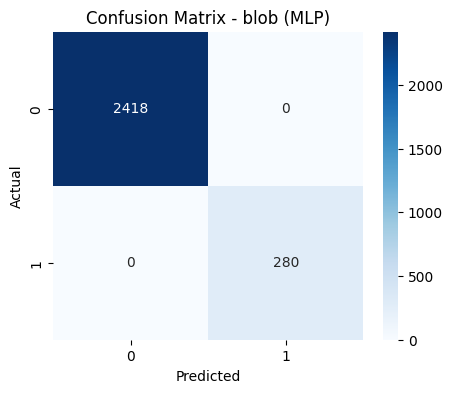

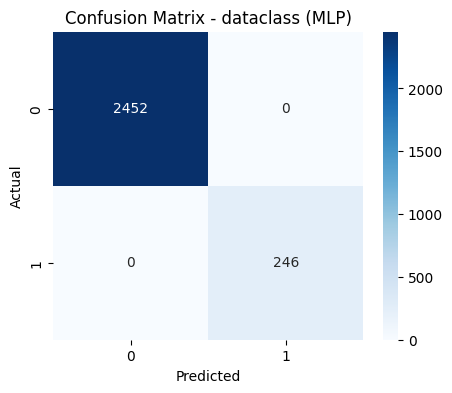

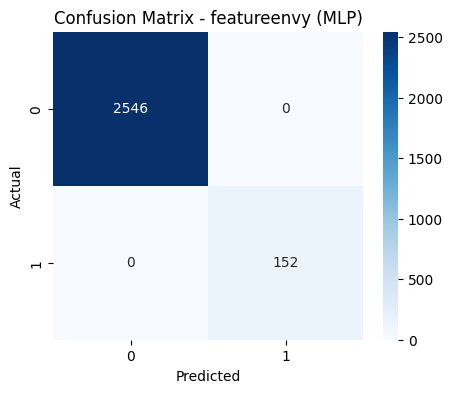

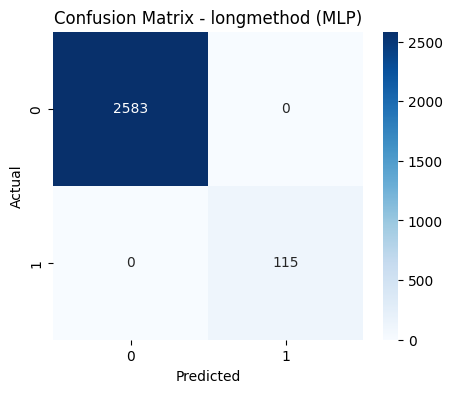

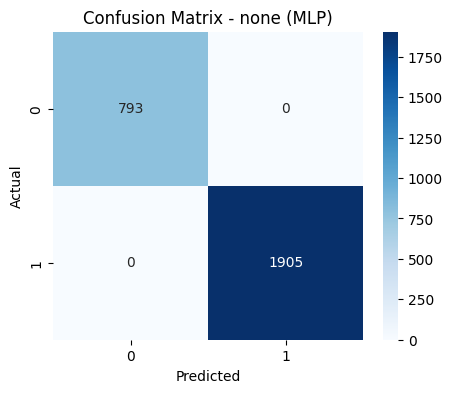

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: CNN
Classification Report:
              precision    recall  f1-score   support

        blob       0.92      0.72      0.81       280
   dataclass       0.98      0.67      0.80       246
 featureenvy       1.00      0.88      0.94       152
  longmethod       0.99      0.77      0.86       115
        none       1.00      0.95      0.97      1905

   micro avg       0.99      0.89      0.94      2698
   macro avg       0.98      0.80      0.88      2698
weighted avg       0.99      0.89      0.93      2698
 samples avg       0.89      0.89      0.89      2698

Acurácia
0.8899184581171238


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


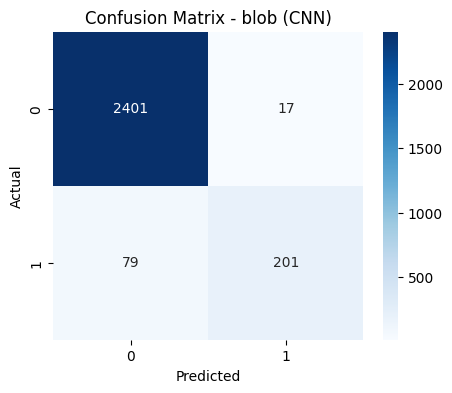

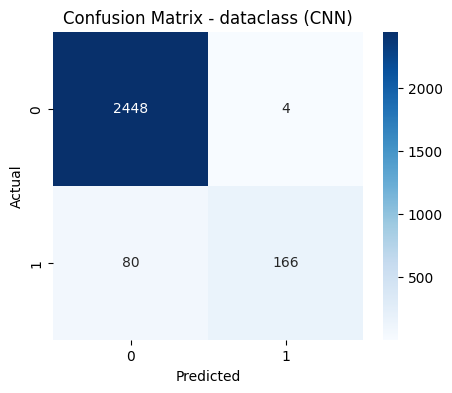

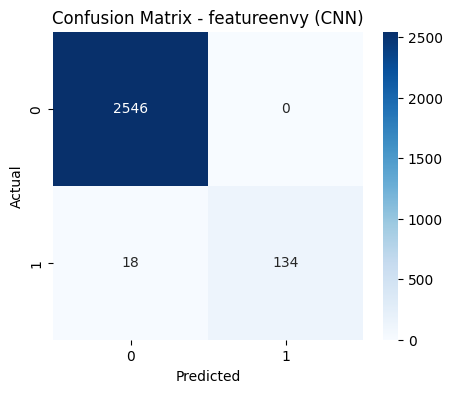

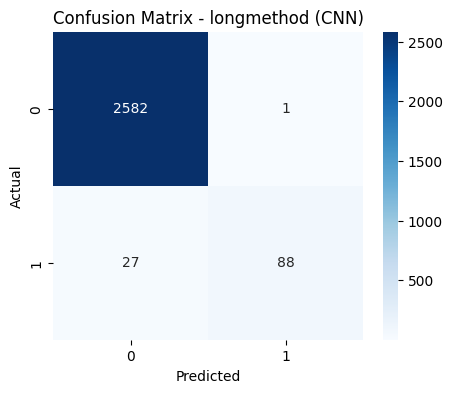

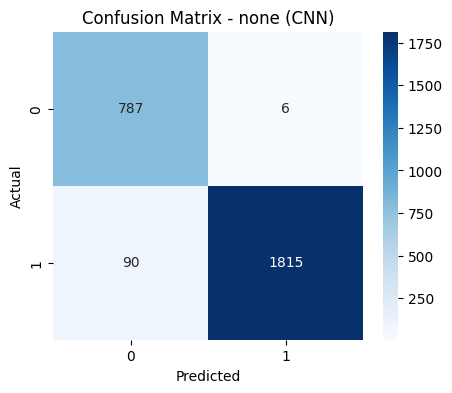

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: GRU
Classification Report:
              precision    recall  f1-score   support

        blob       1.00      1.00      1.00       280
   dataclass       1.00      1.00      1.00       246
 featureenvy       1.00      0.99      0.99       152
  longmethod       1.00      1.00      1.00       115
        none       1.00      1.00      1.00      1905

   micro avg       1.00      1.00      1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698
 samples avg       1.00      1.00      1.00      2698

Acurácia
0.9985174203113417


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


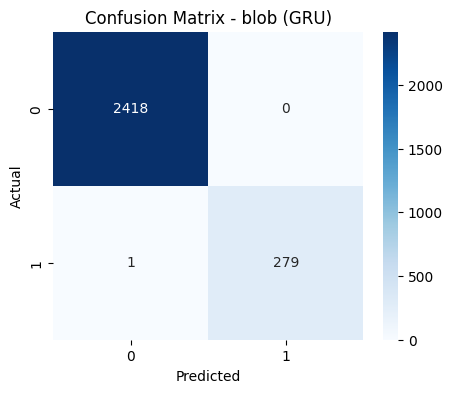

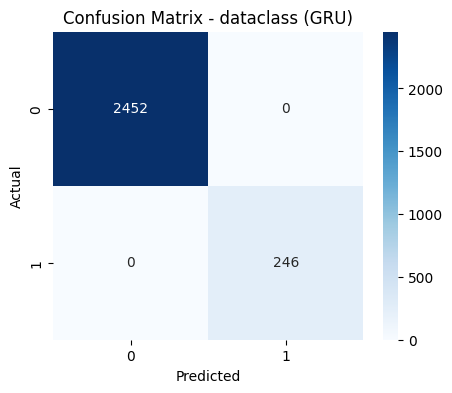

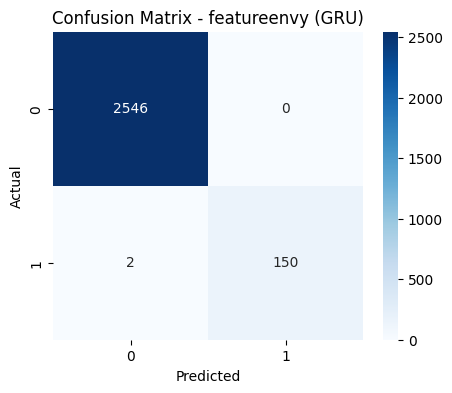

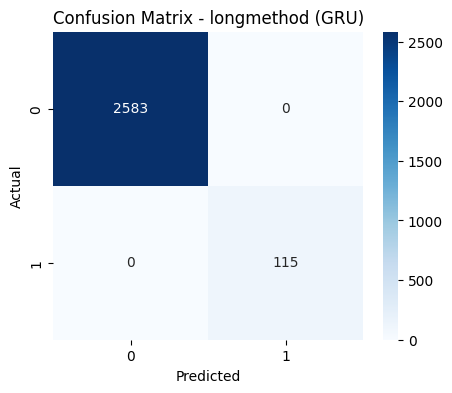

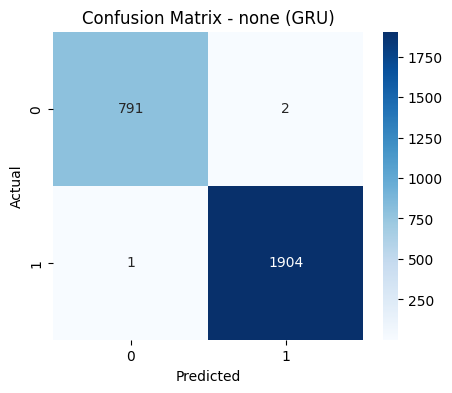

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model: LSTM
Classification Report:
              precision    recall  f1-score   support

        blob       0.00      0.00      0.00       280
   dataclass       0.00      0.00      0.00       246
 featureenvy       0.00      0.00      0.00       152
  longmethod       0.00      0.00      0.00       115
        none       1.00      0.98      0.99      1905

   micro avg       1.00      0.69      0.82      2698
   macro avg       0.20      0.20      0.20      2698
weighted avg       0.71      0.69      0.70      2698
 samples avg       0.69      0.69      0.69      2698

Acurácia
0.6886582653817642


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


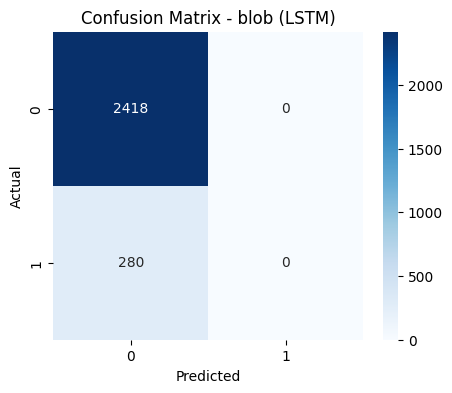

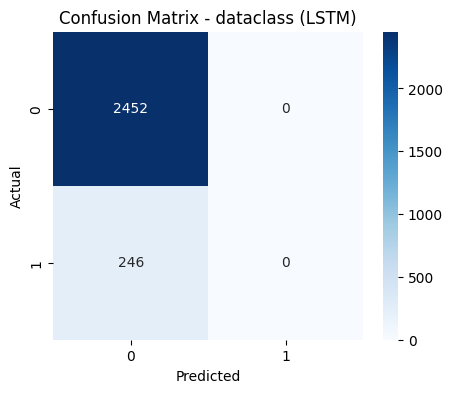

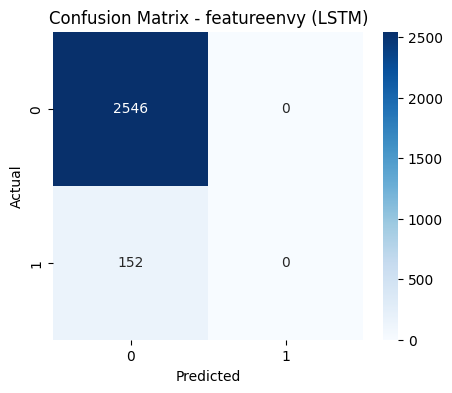

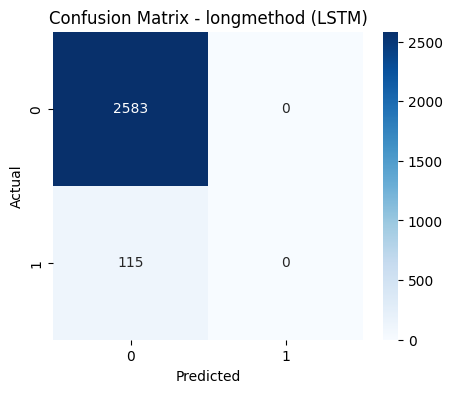

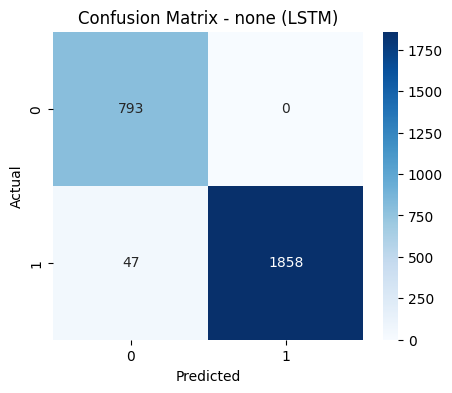

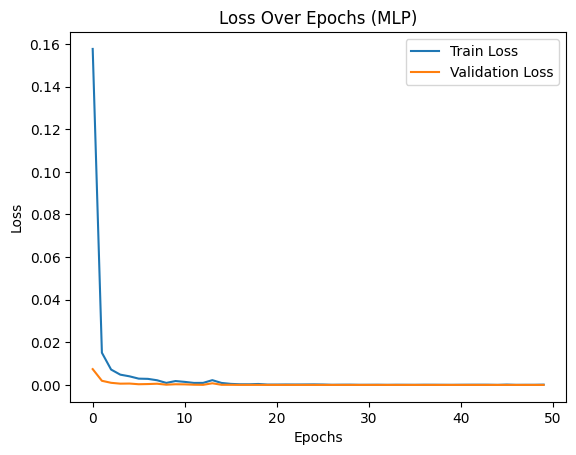

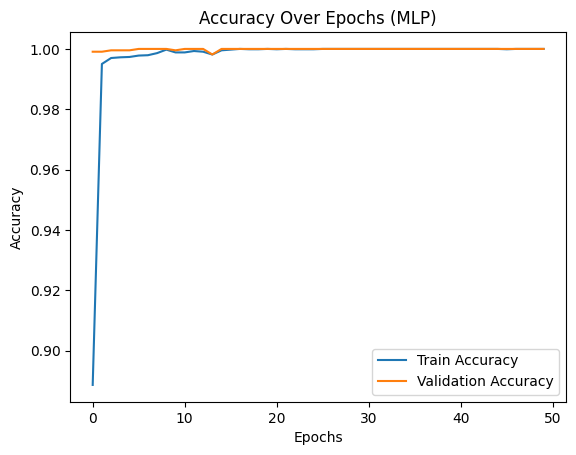

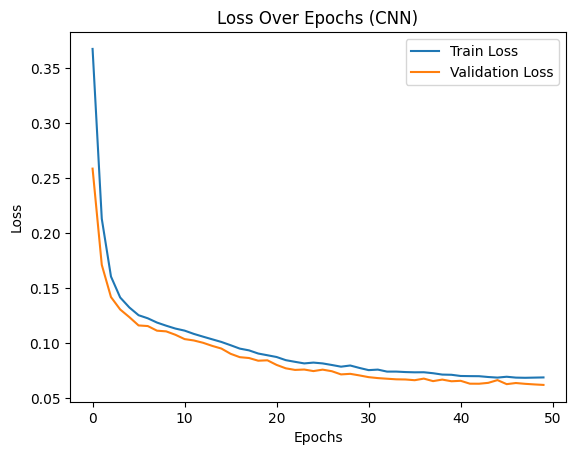

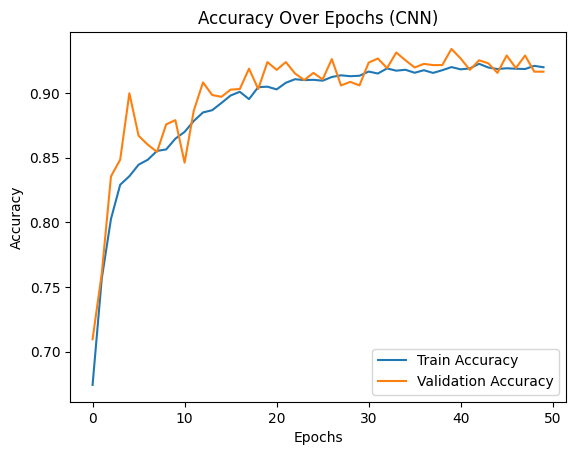

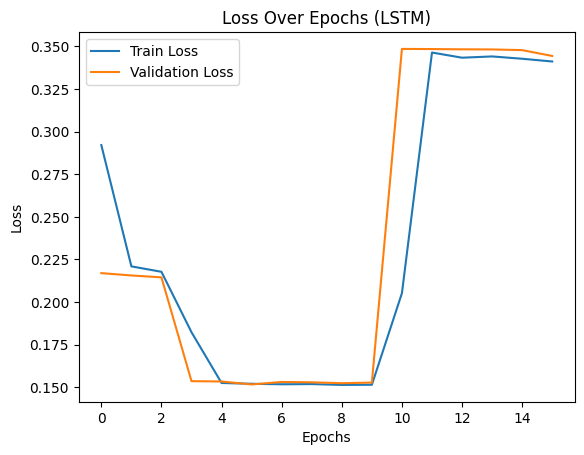

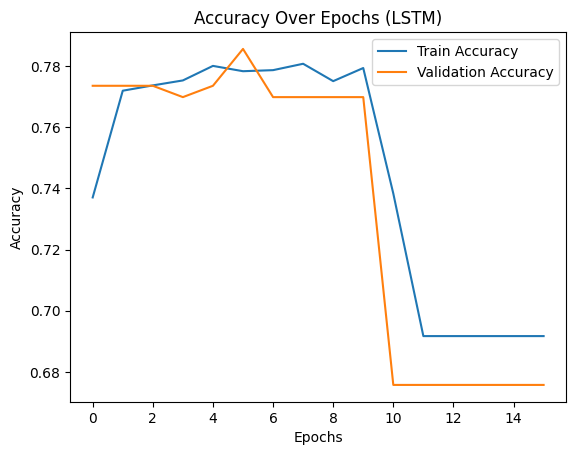

KeyError: 'val_loss'

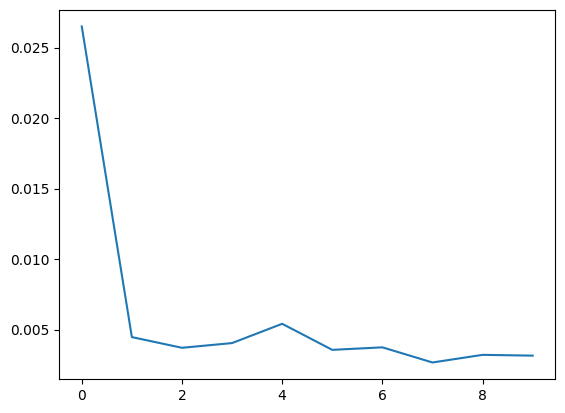

In [10]:
# Step 6: Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    if len(X_test.shape) == 2:  # For MLP
        predictions = model.predict(X_test)
    elif model_name=='CNN' or model_name=='LSTM':  # For CNN and LSTM
        predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    else:
        predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    print(f"\nModel: {model_name}")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=one_hot_encoder.categories_[0]))
    print("Acurácia")
    print(accuracy_score(y_test, predictions))
    conf_matrix = multilabel_confusion_matrix(y_test, predictions)
    for i, label in enumerate(one_hot_encoder.categories_[0]):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {label} ({model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Evaluate all models
evaluate_model(mlp_model, X_test, y_test, "MLP")
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")
evaluate_model(model_gru, X_test_gru, y_test, "GRU")
evaluate_model(lstm_model, X_test_cnn, y_test, "LSTM")
#evaluate_model(history_capsnet, X_test, y_test, "CapsuleNetworks")

# Step 7: Plot Training History
def plot_history(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'Loss Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'Accuracy Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Plot histories
plot_history(mlp_history, "MLP")
plot_history(cnn_history, "CNN")
plot_history(lstm_history, "LSTM")
plot_history(history_gru, "GRU")

# DeleSmell

In [12]:
X_train = X_train.values.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1],1))

In [13]:
units = 1
inp=Input(shape=(X_train.shape[1:]))

In [14]:
x = Conv1D(32, 6, padding = "same", activation='tanh')(inp)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=6, strides=1, padding='same',activation='relu')(x)
#x = Conv1D(64, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(128, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv1D(256, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(256, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = BatchNormalization()(x)
x = Conv1D(512, kernel_size=6, strides=1, padding='same',activation='relu')(x)
x = Conv1D(512, 6, strides=1, padding='same',activation='relu')(x)
x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
g = Flatten()(x)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
activations = Bidirectional(GRU(units,return_sequences = True,dropout=0.2,recurrent_dropout=0.2))(inp)
attention = Dense(1,activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units*2)(attention)
attention = Permute([2,1])(attention)
sent_representation = Multiply()( [activations,attention])
sent_representation = Lambda(lambda xin: K.sum(xin,axis=-2),output_shape=(units*2,))(sent_representation)

In [16]:
l=Dense(128,activation="relu")(sent_representation)
l=Dropout(0.3)(l)
d = Flatten()(l)

In [17]:
g2=concatenate([g,d],axis=1)
q=Dense(128)(g2)
q=LeakyReLU(alpha=0.33)(q)
q=LeakyReLU(alpha=0.33)(q)
q=LeakyReLU(alpha=0.33)(q)
q=Dropout(0.5)(q)
q=Dense(256,activation="tanh")(q)

In [18]:
output = Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(q)
model = Model(inputs=inp,outputs=output)

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss ='hinge',
              metrics = ['accuracy'])

In [20]:
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
predict = model.predict(X_test)
y_pred=np.argmax(predict,axis=1)
print(classification_report(Y_test, y_pred,target_names=one_hot_encoder.categories_[0]))

85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step
              precision    recall  f1-score   support

        blob       0.10      0.91      0.19       280
   dataclass       0.16      0.17      0.17       246
 featureenvy       0.00      0.00      0.00       152
  longmethod       0.00      0.00      0.00       115
        none       0.00      0.00      0.00      1905

    accuracy                           0.11      2698
   macro avg       0.05      0.22      0.07      2698
weighted avg       0.03      0.11      0.03      2698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Auto Keras

In [21]:
!pip3 install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


In [22]:

import tensorflow as tf
import autokeras as ak


# Carregar o dataset
# Substitua 'seu_dataset.csv' pelo caminho do arquivo contendo os code smells
# O dataset deve conter colunas: 'features' (entradas) e 'label' (code smells)
#df = pd.read_csv('seu_dataset.csv')

# Dividir características (X) e rótulos (y)
X = df.drop("agreement_experts_has_smell_name", axis=1)  # Supondo que todas as outras colunas sejam recursos
y = smell



# Codificar os rótulos para valores numéricos
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Padronizar as características numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converter os rótulos para arrays NumPy (garantir formato correto)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Configurar o AutoModel
input_node = ak.Input()
output_node =ak.ClassificationHead()
# Criar o modelo
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=15  # Define quantos modelos serão testados
)

# Treinar o modelo
clf.fit(x=X_train, y=y_train, epochs=20, validation_split=0.2, batch_size=8)

# Avaliar o modelo
accuracy = clf.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy[1]:.4f}")

# Fazer previsões
y_pred = clf.predict(X_test).flatten()
#y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))

# Relatório de Classificação
#print("Relatório de Classificação:")
#print(classification_report(y_test, y_pred, target_names=one_hot_encoder.categories_[0]))



Trial 15 Complete [00h 04m 32s]
val_loss: 8.910637916414998e-07

Best val_loss So Far: 5.832020519846992e-07
Total elapsed time: 00h 42m 51s
Epoch 1/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9027 - loss: 0.3752
Epoch 2/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9968 - loss: 0.0162
Epoch 3/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9969 - loss: 0.0196
Epoch 4/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9977 - loss: 0.0106
Epoch 5/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9981 - loss: 0.0063
Epoch 6/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9981 - loss: 0.0071
Epoch 7/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9988 - loss: 0.0114
Epoch 8/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9983 - loss: 0.0041
Epoch 9/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9988 - loss: 0.0055
Epoch 10/20
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 15s 11

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9999 - loss: 6.9174e-04
Acurácia no conjunto de teste: 0.9996
64/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 65))
  warnings.warn(msg)


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
y_pred = clf.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 10: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=one_hot_encoder.categories_[0]))

# Obter o tuner associado ao AutoModel
tuner = clf.tuner

# Iterar pelos melhores modelos (ou todos)
best_trials = tuner.oracle.get_best_trials(num_trials=10)  # Obter os 10 melhores modelos

for i, trial in enumerate(best_trials):
    print(f"\nModelo {i+1}:")
    print("Hiperparâmetros:")
    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

    # Reconstruir o modelo com os hiperparâmetros
    model = tuner.hypermodel.build(trial.hyperparameters)
    print("\nResumo do Modelo:")
    model.summary()


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:

              precision    recall  f1-score   support

        blob       1.00      1.00      1.00       280
   dataclass       1.00      1.00      1.00       246
 featureenvy       1.00      1.00      1.00       152
  longmethod       1.00      1.00      1.00       115
        none       1.00      1.00      1.00      1905

   micro avg       1.00      1.00      1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698
 samples avg       1.00      1.00      1.00      2698


Modelo 1:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001

Resumo do Mo

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_1 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 2:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: True
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001

Resumo do Modelo:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_2 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 3:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_3 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 4:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_4 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_4 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 5:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 256

Resumo do Modelo:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_5 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_5 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 6:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: True
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam_weight_decay
  learning_rate: 0.0001

Resumo do Modelo:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_6 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_6 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 7:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 256
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 1024

Resumo do Modelo:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_7 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_7 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 8:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 256
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 16
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 64

Resumo do Modelo:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_8 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_8 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 9:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 1024
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 16
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001
  general_block_1/dense_block_1/units_2: 512

Resumo do Modelo:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_9 (Cast)                        │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_9 (CastToFloat32)    │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_19 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 10:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: True
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 512
  classification_head_1/dropout: 0
  optimizer: adam
  learning_rate: 0.0001

Resumo do Modelo:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_10 (Cast)                       │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32_10 (CastToFloat32)   │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_20 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_21 (ReLU)                      │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Softmax)      │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,333 (13.02 KB)

 Trainable params: 3,333 (13.02 KB)

 Non-trainable params: 0 (0.00 B)